# MoBike Lyfecycle Prediction

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics

# Table of Content:
* [0 Load Dataset](#0-Load-Dataset)
* [1 Data Preprocessing](#1-Data-Preprocessing)
  - [1.1 Trim Trip Duration](#1.1-Trim-Trip-Duration)
  - [1.2 Discover Lifecycle Interval](#1.2-Discover-Lifecycle-Interval)
    + [1.2.1 KMeans](#1.2.1-KMeans)
    + [1.2.2 Probability Value](#1.2.2-Probability-Value)
* [2 Data Analysis](#2-Data-Analysis)
  - [2.1 Current Feature Analysis](#2.1-Current-Feature-Analysis)
    + [2.1.1 Lifecycle VS Subscription Ratio](#2.1.1-Lifecycle-VS-Subscription-Ratio)


# 0 Load Dataset

In [23]:
# Load raw trip data
trip_bay = pd.read_csv('Dataset/bay_trip_city.csv', index_col=0)
station = pd.read_csv('Dataset/sf-station.csv')

# Lifecycle dataset is generated by section data preprocessing
lifecycle = pd.read_csv('Dataset/lifecycle_final.csv')

# 1 Data Preprocessing

## 1.1 Trim Trip Duration

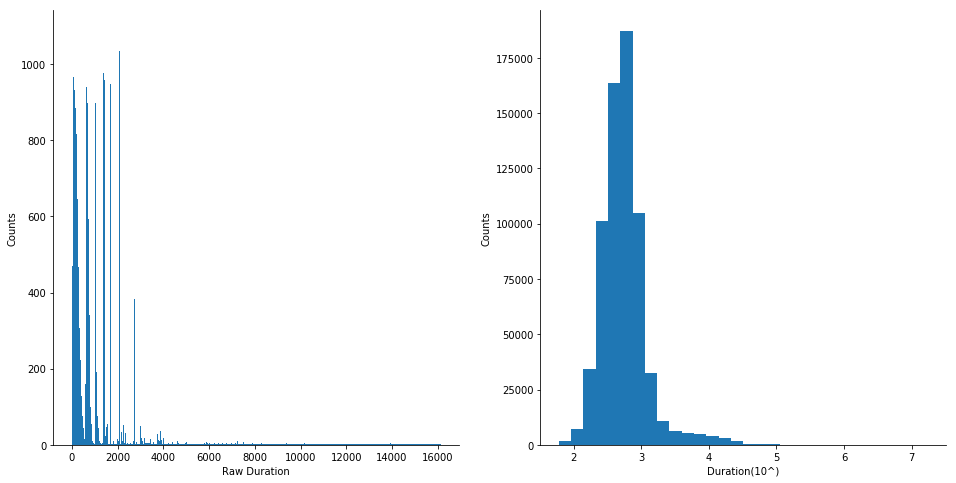

In [25]:
# Check trip duration distribution. We can see that the log data is like normal distribution

# Distribution with raw data
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
labels, values = zip(*Counter(trip_bay.duration).items())
indexes = np.arange(len(labels))
ax1.bar(indexes,values, 1)
plt.xlabel('Raw Duration')
plt.ylabel('Counts')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

## Distribution with log data 
interval_log = np.log10(np.array(trip_bay.duration))
ax2 = plt.subplot(122)
ax2.hist(interval_log, bins=30)
plt.xlabel('Duration(10^)')
plt.ylabel('Counts')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

In [30]:
# Based on the plots, we use logged data to trim trip duration in order to remove some outliers.
trip_mean = np.mean(interval_log)
trip_std = np.std(interval_log)

# Set up upbound and bottom bound. t1 is about 4 hours and t2 is about 2 mins.
t1 = np.mean(interval_log) + 2*np.std(interval_log)
t2 = np.mean(interval_log) - 2*np.std(interval_log)

# Trim raw trips data by t1 and t2
trip = trip_bay[(trip_bay.duration >= 120) & (trip_bay.duration <= 4*3600) ]

## 1.2 Discover Lifecycle Interval

### 1.2.1 KMeans

In [37]:
# Since there is no indicator for a bike's lifecycle, we start from using KMeans to group trips of each bike to try to 
# find lifecycle interval. Using Silhouette coefficient to find the optimal K for a specific bike.

def timedifference(row):
    """Calculate time difference between each trip of a specific bike.
    """
    startdifference = ((row['start_date']-initialstart)/np.timedelta64(1, 'h'))
    enddifference   = ((row['end_date']-initialend)/np.timedelta64(1, 'h'))
    return pd.Series((startdifference, enddifference))

def sil_cal_elbow(X, start, end):
    """Calculate silhouette coeff with different k.
    """
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
    return result_list

def generatetraining(choose_id):
    """Generate subset based on bike id.
    """
    global initialstart
    global initialend
    test = trip[trip.bike_id == choose_id]
    test = test.sort_values('start_date')
    test['start_date']=pd.to_datetime(test['start_date'].values)
    test['end_date']=pd.to_datetime(test['end_date'].values)
    initialstart = test.iloc[0].start_date
    initialend   = test.iloc[0].end_date
    training_feature  = test.apply(timedifference, axis=1)
    training_feature.columns = ['start_diff', 'end_diff']
    return training_feature

def siloutteplot(training_feature):
    """Plot siloutte vs K.
    """
    t = sil_cal_elbow(training_feature, 2, 10)
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    x_axis=list(range(2,11))
    y_axis=t
    ax.plot(x_axis, t, 'b*-')
    plt.xlabel('K')
    plt.ylabel('Coefficient (1 is best, -1 is worst)')
    plt.title('Silhouette coefficient')
    plt.show()

    
def clusterplot(K, training_feature):
    """Plot clutered trips with optimal K.
    """
    km = KMeans(K)
    km.fit(training_feature)
    mu = km.cluster_centers_
    labels = km.labels_
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.scatter(training_feature['start_diff'], training_feature['end_diff'], c=labels, alpha=0.4)
    ax.scatter(mu[:,0], mu[:,1], s=300, c=np.unique(labels))
    plt.xlabel('start time')
    plt.ylabel('end time')
    plt.show()

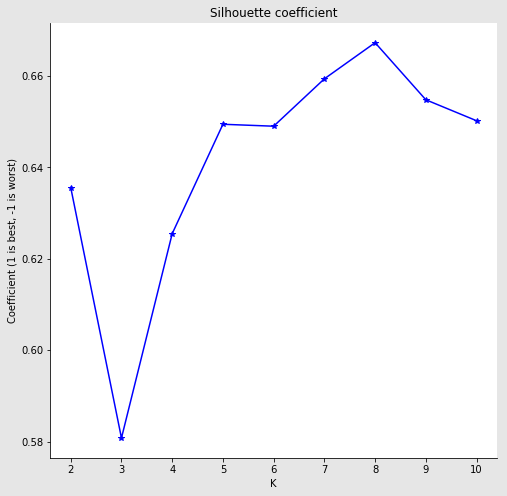

In [38]:
# KMeans with bike_id 9
training_feature = generatetraining(9)
siloutteplot(training_feature)

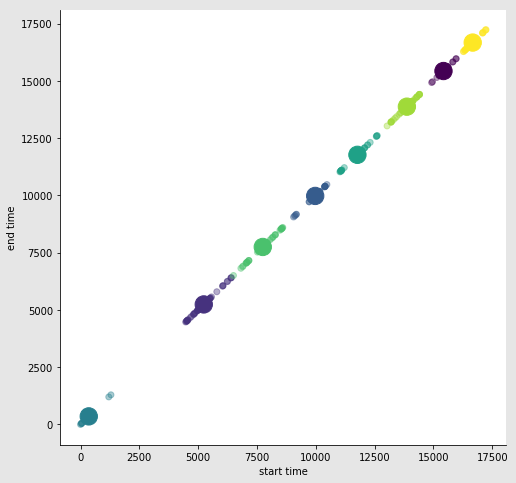

In [39]:
# The optimal K from the above plot is 8. And the clustering for bike id 9 is pretty good
clusterplot(8, training_feature)

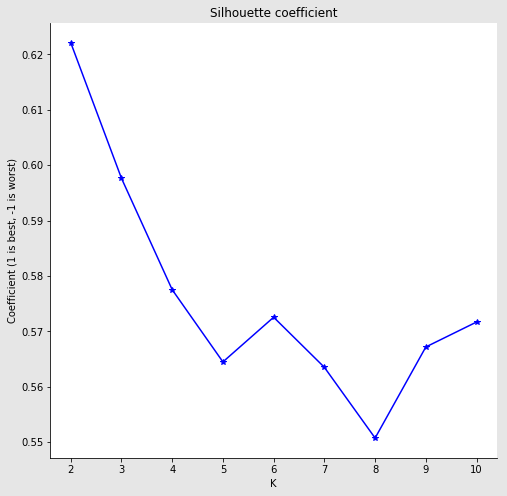

In [40]:
# KMeans with bike_id 342
training_feature = generatetraining(342)
siloutteplot(training_feature)

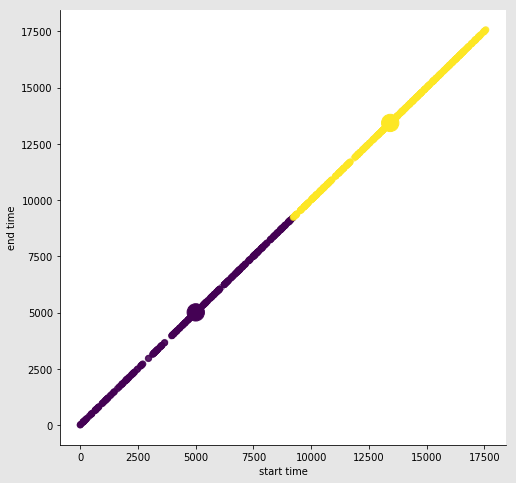

In [41]:
# The optimal K from the above plot is 2. And the clustering for bike id 342 is not that good.
clusterplot(2, training_feature)

From the above two exampels, the method is KMenas fails to find the lifecycle interval for all bikes. So we choose the statistical method to get a reasonal lifecycle interval based on the assumption that lifecycle interval is normal distribution.

### 1.2.2 Probability Value

In [42]:
def collectinterval(dataset):
    """Collect all trip intervals.
    """
    interval_list = []
    bikeid = set(dataset.bike_id.unique())
    for bike_id in bikeid:
        temp = dataset[dataset['bike_id'] == bike_id] 
        temp.loc[:,'start_date'] =pd.to_datetime(temp['start_date'].values)
        temp.loc[:,'end_date'] =pd.to_datetime(temp['end_date'].values)
        temp = temp.sort_values(by=['start_date'])
        for i in range(1, len(temp)):
            t = ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'm')).astype(int)
            interval_list.append(t)
    return interval_list
interval_list = collectinterval(trip)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


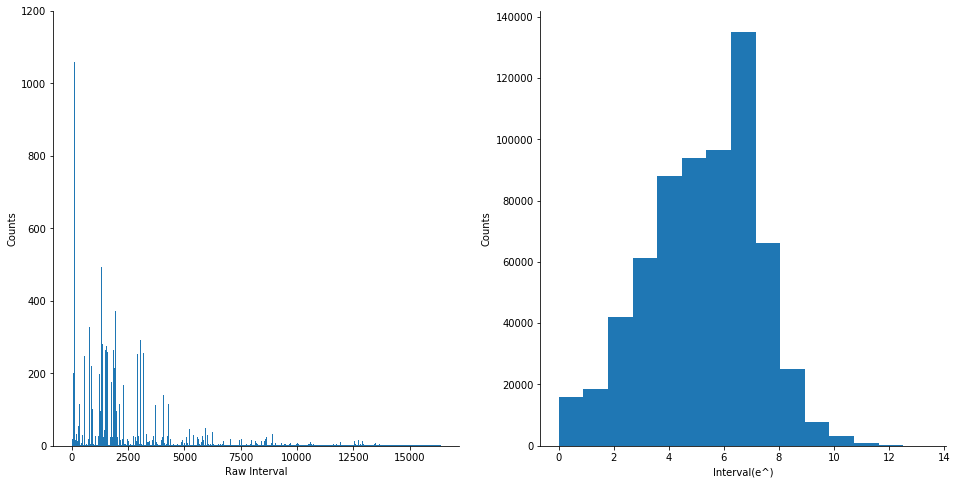

In [50]:
# Check the distribution of all intervals
# Distribution with raw data
plt.figure(figsize=(16, 8))
ax3 = plt.subplot(121)
labels, values = zip(*Counter(interval_list).items())
indexes = np.arange(len(labels))
ax3.bar(indexes,values, 1)
plt.xlabel('Raw Interval')
plt.ylabel('Counts')
ax3.set_ylim(0, 1200)
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

## Distribution with log data 
interval_lg = np.log(np.array(interval_list))
interval_lg = interval_lg[~np.isnan(interval_lg)]
interval_lg = interval_lg[~np.isinf(interval_lg)]
ax4 = plt.subplot(122)
ax4.hist(interval_lg, bins=15)
plt.xlabel('Interval(e^)')
plt.ylabel('Counts')
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')

In [51]:
# Calculate the up bound of interval. We get t ~= 7 and t2 ~= 4
t = np.mean(interval_lg) + 2*np.std(interval_lg)  # 95%
t2 = np.mean(interval_lg) + (1.644)*np.std(interval_lg) # 90%

In [ ]:
def tempcovert(temp):
    """Group trips with the calculated interval
    """
    final_id_list = []
    bike_group = []
    counts = 0
    for i in range(len(temp)):
        old_id = temp.iloc[i].bike_id
        if i == 0:
            bike_group.append(str(old_id) +'_'+str(counts))
        elif i == len(temp)-1:
            bike_group.append(str(old_id) +'_'+str(counts)) 
            final_id = str(old_id) +'_'+str(counts) 
            final_id_list.append(final_id)
        else:
            if (((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 4 and
               temp.iloc[i].start_station_id != temp.iloc[i-1].end_station_id):
                counts += 1
            elif ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 7:
                counts += 1
            bike_group.append(str(old_id) +'_'+str(counts)) 
    result = pd.DataFrame(bike_group, columns = ['bike_group'], index=temp.index)
    temp = pd.concat([temp, result], axis =1)
    return temp, final_id

def generatelifecycle(dataset):
    """Generate new dataset based on lifecycle.
    """
    new_pd = pd.DataFrame()
    finalid_list = []
    id_set = set(dataset.bike_id.unique())
    for bikeid in id_set:
        temp = dataset[dataset['bike_id'] == bikeid]
        temp.sort_values(by=['start_date'])
        temp['start_date'] =pd.to_datetime(temp['start_date'].values)
        temp['end_date'] =pd.to_datetime(temp['end_date'].values)
        temp, final_id = tempcovert(temp)
        new_pd = pd.concat([new_pd, temp])
        finalid_list.append(final_id)
    return new_pd, finalid_list

new_pd, finalid_list = generatelifecycle(trip)
new_pd_removelast = new_pd[~new_pd['bike_group'].isin(finalid_list)]
new_pd_removelast.to_csv('Dataset/lifecycle_final.csv')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 2 Data Analysis

## 2.1 Current Feature Analysis

### 2.1.1 Lifecycle VS Subscription Ratio

In [ ]:
station['start_station_id'] = station['id']

# Get the duration for a lifecycle
duration = pd.DataFrame()
a = lifecycle[['bike_group', 'duration']].groupby(['bike_group']).sum()
duration['bike_group'] = a.index
duration['duration'] = a.duration.values

# Get the subscribe_type sum
subscriber = pd.DataFrame()
customer = pd.DataFrame()
b = lifecycle.loc[lifecycle.subscription_type=="Subscriber"][['bike_group', 'subscription_type']].groupby(['bike_group']).count()
c = lifecycle.loc[lifecycle.subscription_type=="Customer"][['bike_group', 'subscription_type']].groupby(['bike_group']).count()
subscriber['bike_group'] = b.index
subscriber['subscriber'] = b.subscription_type.values
customer['bike_group'] = c.index
customer['customer'] = c.subscription_type.values

# Get the trips count
trips = pd.DataFrame()
d = lifecycle[['bike_group', 'id']].groupby(['bike_group']).count()
trips['bike_group'] = d.index
trips['trips number'] = d.id.values

bdata = pd.merge(duration, subscriber, on="bike_group", how="left")
bdata = pd.merge(bdata, customer, on="bike_group", how="left")
bdata = bdata.fillna(0)
bdata = pd.merge(bdata, trips, on="bike_group", how="left")
bdata['total subscribe types'] = bdata['subscriber'] + bdata['customer']
bdata['subscriber ratio'] = bdata['subscriber']/bdata['total subscribe types']

# Merge geo 
bdata['start_station_id'] = lifecycle['start_station_id']
bdata = pd.merge(bdata, station[['start_station_id', 'lat', 'long']], on='start_station_id', how="left")

In [ ]:
# First plot: Bike LifeCycle V.S. Subscriber Ratio
plt.figure(figsize=(16, 8))
ax5 = plt.subplot(111)
ax5.scatter(bdata['subscriber ratio'], bdata['duration'], color='b', alpha=0.2)
plt.xlabel('Subscriber Ratio')
plt.ylabel('LifeCycle')
plt.title('Bike LifeCycle V.S. Subscriber Ratio')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

### 2.1.2 Lifecycle VS Trips Number

### 2.1.3  Station VS Lifecycle

### 2.1.4 Station VS Crime

### 2.1.5 Lifecycle VS Period

### 2.1.6 Lifecycle VS Parked Period


## 2.2 Weather 

## 2.3 Income

## 2.4 Education

## 2.5 Crime

## 2.6 Finalize Dataset

# 3 Modeling

## 3.1 Linear Regression

### 3.1.1 Fitting Model

### 3.1.2 Error Analysis

## 3.2 Random Forest

### 3.2.1 Fitting Model

### 3.2.2 Error Analysis

## 3.3 Neural Network

### 3.3.1 Fitting Model

### 3.3.2 Error Analysis